In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import grid_search
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

from random import seed
from random import randrange

import pickle
%matplotlib inline

C:\Users\Asavari\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Asavari\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Reading the raw data into a dataframe

In [2]:
#decision_date and case_recieved_date are read as dates
df = pd.read_csv('us_perm_visas.csv', low_memory = False, parse_dates=['decision_date', 'case_received_date'],\
                 index_col = ['case_no'])

In [3]:
#Removing all withdrawn applications
df = df[df.case_status != 'Withdrawn']

#Combining certified-expired and certified applications
df.loc[df.case_status == 'Certified-Expired', 'case_status'] = 'Certified'

#Now only two labels, Certified and Denied, which are stored in the column case_status

In [4]:
#Convering the date to just the year
df['year'] = df['case_received_date'].dt.year

In [5]:
#Dropping all empty columns
df = df.dropna(axis=1, how='all');

#Dropping all empty rows
df = df.dropna(axis=0, how='all');

In [6]:
#Dropping all rows with any missing values
df_nona = df.dropna(axis=0, how='any');

df_nona.info()

#This shows that dropping rows with empty values is not an option

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 154 entries, add_these_pw_job_title_9089 to year
dtypes: datetime64[ns](2), float64(11), object(141)
memory usage: 0.0+ bytes


### Visualisation of the Unprocessed Data

In [7]:
pd.set_option('display.max_colwidth', -1)

In [8]:
i = 0
count_nonnan = [];
ct = [];

for col in df.columns:
    i+=1
    count_nonnan.append(df[col].count())
    ct.append(i)

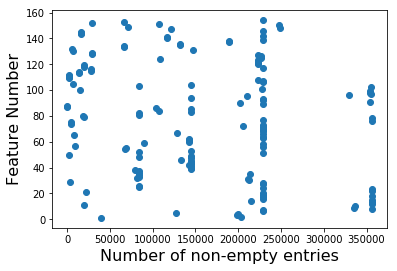

In [9]:
plt.scatter(count_nonnan, ct)
plt.ylabel('Feature Number', fontsize=16)
plt.xlabel('Number of non-empty entries', fontsize=16)

#This is a scatterplot to show the number of non-empty values per feature

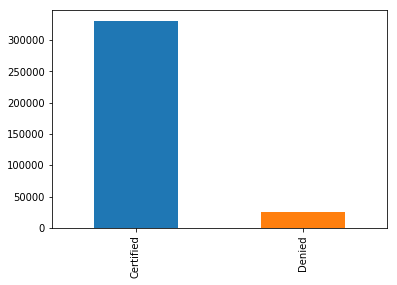

In [10]:
#Total Number of data points of each class
df['case_status'].value_counts().plot(kind = 'bar')

There are 201 different countries of citizenship in this dataset


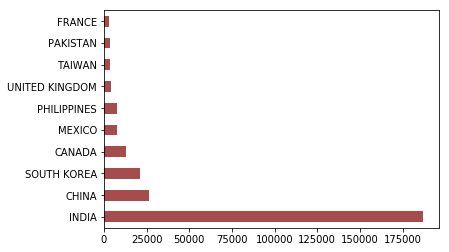

In [11]:
print('There are', df['country_of_citizenship'].value_counts().count(), \
      'different countries of citizenship in this dataset')
df['country_of_citizenship'].value_counts().head(10).plot(kind = 'barh',color = 'maroon', alpha=0.7)

#Graph showing the number of applicants from the countried with the 10 highest number of applicants and the total number of countries

C:\Users\Asavari\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


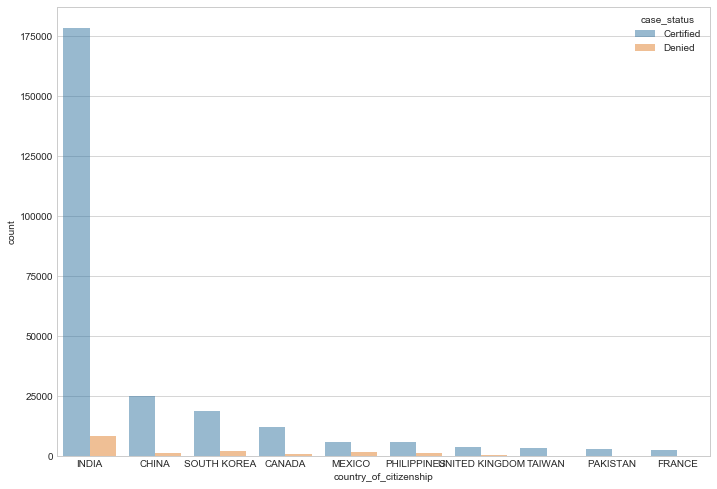

In [12]:
#Graph showing the number of Certified and Denied visa applications for the top 10 countries by number of visa applicants

sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(ax = ax, x='country_of_citizenship', data = df, hue='case_status', \
              order=df.country_of_citizenship.value_counts().iloc[:10].index,alpha = 0.5)#, palette=pkmn_type_colors)

### Feature Selection

In [13]:
#Displaying percentage of non-null values for each feature

i = 0;
for col in df.columns:
    i = i+1;
    print (i-1, col, 100*df[col].count()/len(df['case_status']))

0 add_these_pw_job_title_9089 10.9883538106
1 agent_city 56.91583747
2 agent_firm_name 55.7383032726
3 agent_state 56.0477078233
4 application_type 35.6146537589
5 case_number 64.3853462411
6 case_received_date 64.3853462411
7 case_status 100.0
8 class_of_admission 94.0800408796
9 country_of_citizenship 94.5890703264
10 country_of_citzenship 5.39548752274
11 decision_date 100.0
12 employer_address_1 99.9896116439
13 employer_address_2 60.4046405067
14 employer_city 99.9971923362
15 employer_country 64.3651310617
16 employer_decl_info_title 64.374957885
17 employer_name 99.997753869
18 employer_num_employees 64.3637272298
19 employer_phone 64.3755194178
20 employer_phone_ext 6.31668201523
21 employer_postal_code 99.9907347095
22 employer_state 99.9896116439
23 employer_yr_estab 64.3477235462
24 foreign_worker_info_alt_edu_experience 23.6643943308
25 foreign_worker_info_birth_country 23.6652366299
26 foreign_worker_info_city 64.3777655488
27 foreign_worker_info_education 64.3743963523
28

In [14]:
#Finding relation between case_received_date and decision_date
df[['case_received_date', 'decision_date']]

#Since they are almost the same, and the decision_date is 100% filled, we can drop case_recieved_date

,case_received_date,decision_date
case_no,,
A-07323-97014,NaT,2012-02-01
A-07332-99439,NaT,2011-12-21
A-07333-99643,NaT,2011-12-01
A-07339-01930,NaT,2011-12-01
A-07345-03565,NaT,2012-01-26
A-07352-06288,NaT,2012-01-26
A-07354-06926,NaT,2011-10-07
A-08004-10147,NaT,2012-02-06
A-08004-10184,NaT,2012-02-29


In [15]:
#Indices of selected features
a = [2,3,7,8,9,11,15,17,18,22,23,77,90,96,98,101];

#These features were selected based on the number of empty values and relevance to the visa application decision

df2 = df.iloc[:,a];
df2 = df2.dropna(thresh=0.5*len(df), axis=1);
df2.info()

#selected features are displayed

<class 'pandas.core.frame.DataFrame'>
Index: 356168 entries, A-07323-97014 to nan
Data columns (total 16 columns):
agent_firm_name           198522 non-null object
agent_state               199624 non-null object
case_status               356168 non-null object
class_of_admission        335083 non-null object
country_of_citizenship    336896 non-null object
decision_date             356168 non-null datetime64[ns]
employer_country          229248 non-null object
employer_name             356160 non-null object
employer_num_employees    229243 non-null float64
employer_state            356131 non-null object
employer_yr_estab         229186 non-null float64
job_info_work_state       356072 non-null object
pw_amount_9089            353965 non-null object
pw_soc_code               355778 non-null object
pw_source_name_9089       354081 non-null object
pw_unit_of_pay_9089       354687 non-null object
dtypes: datetime64[ns](1), float64(2), object(13)
memory usage: 56.2+ MB


### Selected Features

In [16]:
import matplotlib.colors as mcolors

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])

    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
[c('red'), 0.125, c('red'), c('orange'), 0.25, c('orange'),c('green'),0.5, c('green'),0.7, c('green'), c('blue'), 0.75, c('blue')])

N = 60
x = np.arange(N).astype(float)
#y = np.random.uniform(0, 5, size=(N,))

#plt.bar(x,y, color=rvb(x/N),alpha = 0.5)
#plt.show()


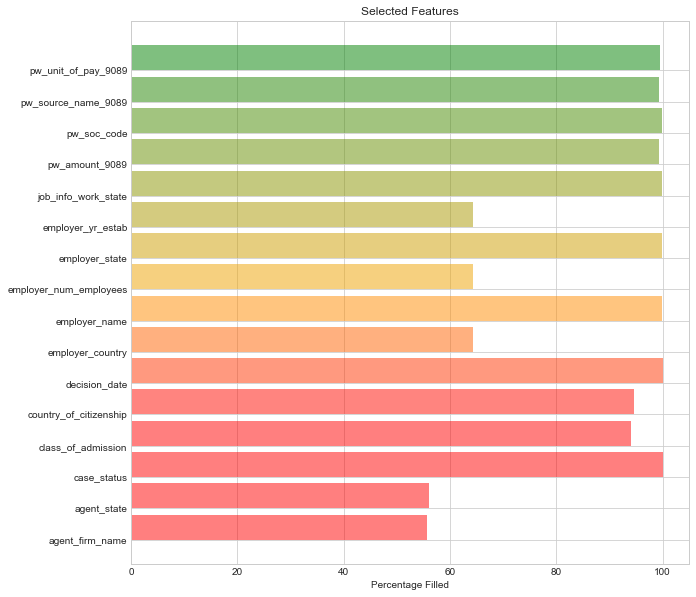

In [17]:

#Displaying percentage of non-null values for each selected feature
objects = []
counts = []
i = 0;
for col in df2.columns:
    i = i+1;
    objects.append(col)
    counts.append(100*df2[col].count()/len(df2['case_status']))
    
y_pos = np.arange(len(objects))
plt.figure(figsize=(10, 10))  # width:20, height:3
plt.barh(y_pos, counts, align='edge', alpha=0.5, color = rvb(x/30))
plt.yticks(y_pos, objects)
plt.xlabel('Percentage Filled')
plt.title('Selected Features')
 
plt.show()

#Features with more than 90% non-empty values can be filled in using the mean/mode
#Features with lesser than 90% non-empty values, other methods are used

### Data Cleaning

In [18]:
#Assigning Labels to Case Status
df2.loc[df.case_status == 'Certified', 'case_status'] = 1
df2.loc[df.case_status == 'Denied', 'case_status'] = 0

#Calculating pay based on unit of pay and wage
di = {"Year": 1, "yr": 1, "Hour": 2080, "hr": 2080, "Week": 52, "wk": 52, "Bi-Weekly": 26,"bi": 26, "Month": 12, "mth": 12}
df2['pw_unit_of_pay_9089'].replace(di, inplace=True)

#Changing datatype of pay to float
df2['pw_amount_9089'] = df2['pw_amount_9089'].str.replace(',', '')
df2[['pw_amount_9089', 'pw_unit_of_pay_9089']] = df2[['pw_amount_9089', 'pw_unit_of_pay_9089']].astype(float)
df2['pw_amount_9089_new'] = df2['pw_amount_9089']*df2['pw_unit_of_pay_9089']
df2['pw_amount_9089_new']=df2['pw_amount_9089_new'].fillna((df2['pw_amount_9089_new'].mean()))

#Dropping redundant pay related features
df2 = df2.drop('pw_amount_9089', 1)
df2 = df2.drop('pw_unit_of_pay_9089', 1)

In [19]:
#Extracting year from decision date and converting to an integer value
df2['decision_date'] = df2['decision_date'].dt.year
df2['decision_date'] = df2['decision_date'].astype(int)
df2['decision_date']=df2['decision_date'].fillna((df2['decision_date'].mean()))

In [20]:
#Since there are too many unknown values, it is treated as a new value
df2['agent_state'].fillna('Unknown');

#Mapping from state name to short-form
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Northern Mariana Islands':'MP', 
    'Palau': 'PW', 
    'Puerto Rico': 'PR', 
    'Virgin Islands': 'VI', 
    'District of Columbia': 'DC'
}

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
df2['agent_state'].replace(us_state_abbrev, inplace=True)
df2.agent_state = df2.agent_state.astype(str)


In [21]:
#Similarly for Employer State
df2['employer_state'] = df2['employer_state'].fillna(df2['employer_state'].mode()[0]);

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
df2['employer_state'].replace(us_state_abbrev, inplace=True)
df2.employer_state = df2.employer_state.astype(str)


#Similarly for Job info work State
df2['job_info_work_state'] = df2['job_info_work_state'].fillna(df2['job_info_work_state'].mode()[0]);

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
df2['job_info_work_state'].replace(us_state_abbrev, inplace=True)
df2.job_info_work_state = df2.job_info_work_state.astype(str)



In [22]:
#df2['employer_postal_code'] = df2['employer_postal_code'].str.replace('.','')
#df2['employer_postal_code'] = df2['employer_postal_code'].str.replace('-','')
#df2['employer_postal_code'] = df2['employer_postal_code'].astype(str).str[0:4]
#empty_emp_index = df2['employer_postal_code'] == "nan"
#df2['employer_postal_code'][empty_emp_index] = '0000';
#not_num_values = df2['employer_postal_code'].str.contains('[a-zA-Z]')
#df2['employer_postal_code'][not_num_values] = '0000';
#df2['employer_postal_code'] = df2['employer_postal_code'].astype(int)
df2['pw_soc_code'] = df2['pw_soc_code'].str.replace('.','')
df2['pw_soc_code'] = df2['pw_soc_code'].str.replace('-','')
df2['pw_soc_code'] = df2['pw_soc_code'].astype(str).str[0:6]
df2['pw_soc_code'].value_counts()
empty_soc_index = df2['pw_soc_code'] == "nan"
df2['pw_soc_code'][empty_soc_index] = df2['pw_soc_code'].mode()[0];

empty_soc_index = df2['pw_soc_code'] == "None"
df2['pw_soc_code'][empty_soc_index] = df2['pw_soc_code'].mode()[0];

C:\Users\Asavari\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Asavari\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
df2['pw_soc_code'] = df2['pw_soc_code'].astype(float)

df2['pw_soc_code'] = df2['pw_soc_code'].astype(int)

df2['case_status'] = df2['case_status'].astype(int)

In [24]:
#Displaying percentage of non-null values for each selected feature

i = 0;
for col in df2.columns:
    i = i+1;
    print (i-1, col, 100*df2[col].count()/len(df2['case_status']))

0 agent_firm_name 55.7383032726
1 agent_state 100.0
2 case_status 100.0
3 class_of_admission 94.0800408796
4 country_of_citizenship 94.5890703264
5 decision_date 100.0
6 employer_country 64.3651310617
7 employer_name 99.997753869
8 employer_num_employees 64.3637272298
9 employer_state 100.0
10 employer_yr_estab 64.3477235462
11 job_info_work_state 100.0
12 pw_soc_code 100.0
13 pw_source_name_9089 99.4140405651
14 pw_amount_9089_new 100.0


In [25]:
#Replace the values with the mode or mean
df2['class_of_admission']=df2['class_of_admission'].fillna((df2['class_of_admission'].mode()[0]))

df2['country_of_citizenship']=df2['country_of_citizenship'].fillna((df2['country_of_citizenship'].mode()[0]))

#df2['employer_city']=df2['employer_city'].fillna((df2['employer_city'].mode()[0]))

df2['employer_name']=df2['employer_name'].fillna((df2['employer_name'].mode()[0]))
df2['employer_name']=df2['employer_name'].astype(str).str.upper()


#df2['job_info_work_city']=df2['job_info_work_city'].astype(str).str.upper()
#df2['job_info_work_city']=df2['job_info_work_city'].fillna((df2['job_info_work_city'].mode()[0].upper()))


df2['pw_source_name_9089']=df2['pw_source_name_9089'].fillna((df2['pw_source_name_9089'].mode()[0]))


df2['pw_soc_code'] = df2['pw_soc_code'].astype(str)
df2['pw_soc_code'] = df2['pw_soc_code'].str.replace('-', '')
df2['pw_soc_code'] = df2['pw_soc_code'].str[0:6]

df2['pw_soc_code']=df2['pw_soc_code'].fillna((df2['pw_soc_code'].mode()[0]))

df2['employer_yr_estab']=df2['employer_yr_estab'].fillna(1700.0)
df2['employer_yr_estab'] = df2['employer_yr_estab'].astype(int)
df2['employer_yr_estab'].value_counts()
df2.loc[df['employer_yr_estab'] < 1700, 'employer_yr_estab'] = 1700

df2['employer_country']=df2['employer_country'].fillna((df2['employer_country'].mode()[0]))

df2['employer_num_employees']=df2['employer_num_employees'].fillna((df2['employer_num_employees'].mean()))


In [26]:
#Displaying percentage of non-null values for each selected feature

i = 0;
for col in df2.columns:
    i = i+1;
    print (i-1, col, 100*df2[col].count()/len(df2['case_status']))

0 agent_firm_name 55.7383032726
1 agent_state 100.0
2 case_status 100.0
3 class_of_admission 100.0
4 country_of_citizenship 100.0
5 decision_date 100.0
6 employer_country 100.0
7 employer_name 100.0
8 employer_num_employees 100.0
9 employer_state 100.0
10 employer_yr_estab 100.0
11 job_info_work_state 100.0
12 pw_soc_code 100.0
13 pw_source_name_9089 100.0
14 pw_amount_9089_new 100.0


### Visualizing the filled features

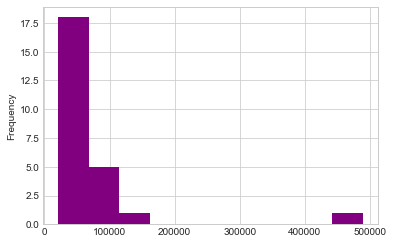

In [27]:
df2['pw_amount_9089_new'].head(25).plot(kind='hist',color = 'purple')


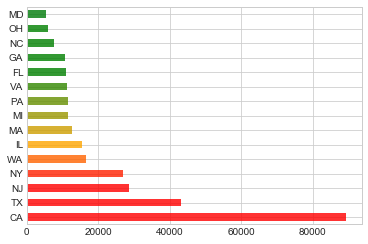

In [28]:
df2['employer_state'].value_counts().head(15).plot(kind='barh',color= rvb(x/20),alpha = 0.8)

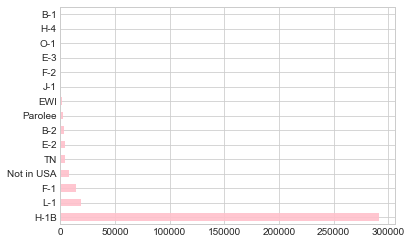

In [29]:
df2['class_of_admission'].value_counts().head(15).plot(kind='barh',alpha = 0.9, color ='pink')

### Converting all data to Categories

In [31]:
converter_dict = {}
#Categorising agent firm name
df2.agent_firm_name = df2.agent_firm_name.astype(str)

le_agent_state = preprocessing.LabelEncoder()
le_agent_state.fit(df2['agent_state'])
df2['agent_state'] = le_agent_state.transform(df2['agent_state'])
converter_dict["agent_state"] = le_agent_state

le_employer_state = preprocessing.LabelEncoder()
le_employer_state.fit(df2['employer_state'])
df2['employer_state'] = le_employer_state.transform(df2['employer_state'])
converter_dict["employer_state"] = le_employer_state

le_agent_firm_name = preprocessing.LabelEncoder()
le_agent_firm_name.fit(df2['agent_firm_name'])
df2['agent_firm_name'] = le_agent_firm_name.transform(df2['agent_firm_name'])
converter_dict["agent_firm_name"] = le_agent_firm_name

le_class_of_admission = preprocessing.LabelEncoder()
le_class_of_admission.fit(df2['class_of_admission'])
df2['class_of_admission'] = le_class_of_admission.transform(df2['class_of_admission'])
converter_dict["class_of_admission"] = le_class_of_admission

le_country_of_citizenship = preprocessing.LabelEncoder()
le_country_of_citizenship.fit(df2['country_of_citizenship'])
df2['country_of_citizenship'] = le_country_of_citizenship.transform(df2['country_of_citizenship'])
converter_dict["country_of_citizenship"] = le_country_of_citizenship

#employer_city
#le_employer_city = preprocessing.LabelEncoder()
#le_employer_city.fit(df2['employer_city'])
#df2['employer_city'] = le_employer_city.transform(df2['employer_city'])
#converter_dict["employer_city"] = le_employer_city

#employer_country
le_employer_country = preprocessing.LabelEncoder()
le_employer_country.fit(df2['employer_country'])
df2['employer_country'] = le_employer_country.transform(df2['employer_country'])
converter_dict["employer_country"] = le_employer_country

#employer_name
le_employer_name = preprocessing.LabelEncoder()
le_employer_name.fit(df2['employer_name'])
df2['employer_name'] = le_employer_name.transform(df2['employer_name'])
converter_dict["employer_name"] = le_employer_name

#job_info_work_ciity
#le_job_info_work_city = preprocessing.LabelEncoder()
#le_job_info_work_city.fit(df2['job_info_work_city'])
#df2['job_info_work_city'] = le_job_info_work_city.transform(df2['job_info_work_city'])
#converter_dict["job_info_work_city"] = le_job_info_work_city

#job_info_work_state
le_job_info_work_state = preprocessing.LabelEncoder()
le_job_info_work_state.fit(df2['job_info_work_state'])
df2['job_info_work_state'] = le_job_info_work_state.transform(df2['job_info_work_state'])
converter_dict["job_info_work_state"] = le_job_info_work_state

#pw_source_name_9089
le_pw_source_name_9089 = preprocessing.LabelEncoder()
le_pw_source_name_9089.fit(df2['pw_source_name_9089'])
df2['pw_source_name_9089'] = le_pw_source_name_9089.transform(df2['pw_source_name_9089'])
converter_dict["pw_source_name_9089"] = le_pw_source_name_9089

print (converter_dict)

f = open("saved_mapping","wb")
pickle.dump(converter_dict, f)
f.close()

{'agent_state': LabelEncoder(), 'employer_state': LabelEncoder(), 'agent_firm_name': LabelEncoder(), 'class_of_admission': LabelEncoder(), 'country_of_citizenship': LabelEncoder(), 'employer_country': LabelEncoder(), 'employer_name': LabelEncoder(), 'job_info_work_state': LabelEncoder(), 'pw_source_name_9089': LabelEncoder()}


In [ ]:
f = open("data","wb")
pickle.dump(df2, f)
f.close()

In [ ]:
f = open("data","rb")
df2 = pickle.load(f)
f.close()